In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima

plt.rcParams['figure.figsize'] = (25,20)

import warnings
warnings.filterwarnings('ignore')

In [85]:
def print_adf(data):
    """ 
    Prints the results of the augmented Dickey Fuller Test
    """
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f""" 
              adf_stats: {adf_stats}
              p: {p} 
              used lag: {used_lag} 
              number of observations: {n_obs}
            
              CI 99%: {levels['1%']}
              CI 95%: {levels['5%']}
              CI 90%: {levels['10%']}
              information criterion (AIC): {information_criterion}
            """)

# Read & pre-processing on train data

In [88]:
df_train = pd.read_csv('df_train.csv')

In [89]:
df_train['date'] = df_train['date'].astype(str)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')

In [90]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20088 entries, 1965-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    20088 non-null  float64
dtypes: float64(1)
memory usage: 313.9 KB


# Based on data explotory within 'temp-data' script, limits for ARIMA model are chosen

In [12]:
auto_arima_model = auto_arima(df_train['temp'], start_p=0, start_q=0, max_p=4, max_q=5, max_d=5)

In [13]:
auto_arima_model

ARIMA(order=(4, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [91]:
model = ARIMA(df_train['temp'], order=(4,1,1)).fit()

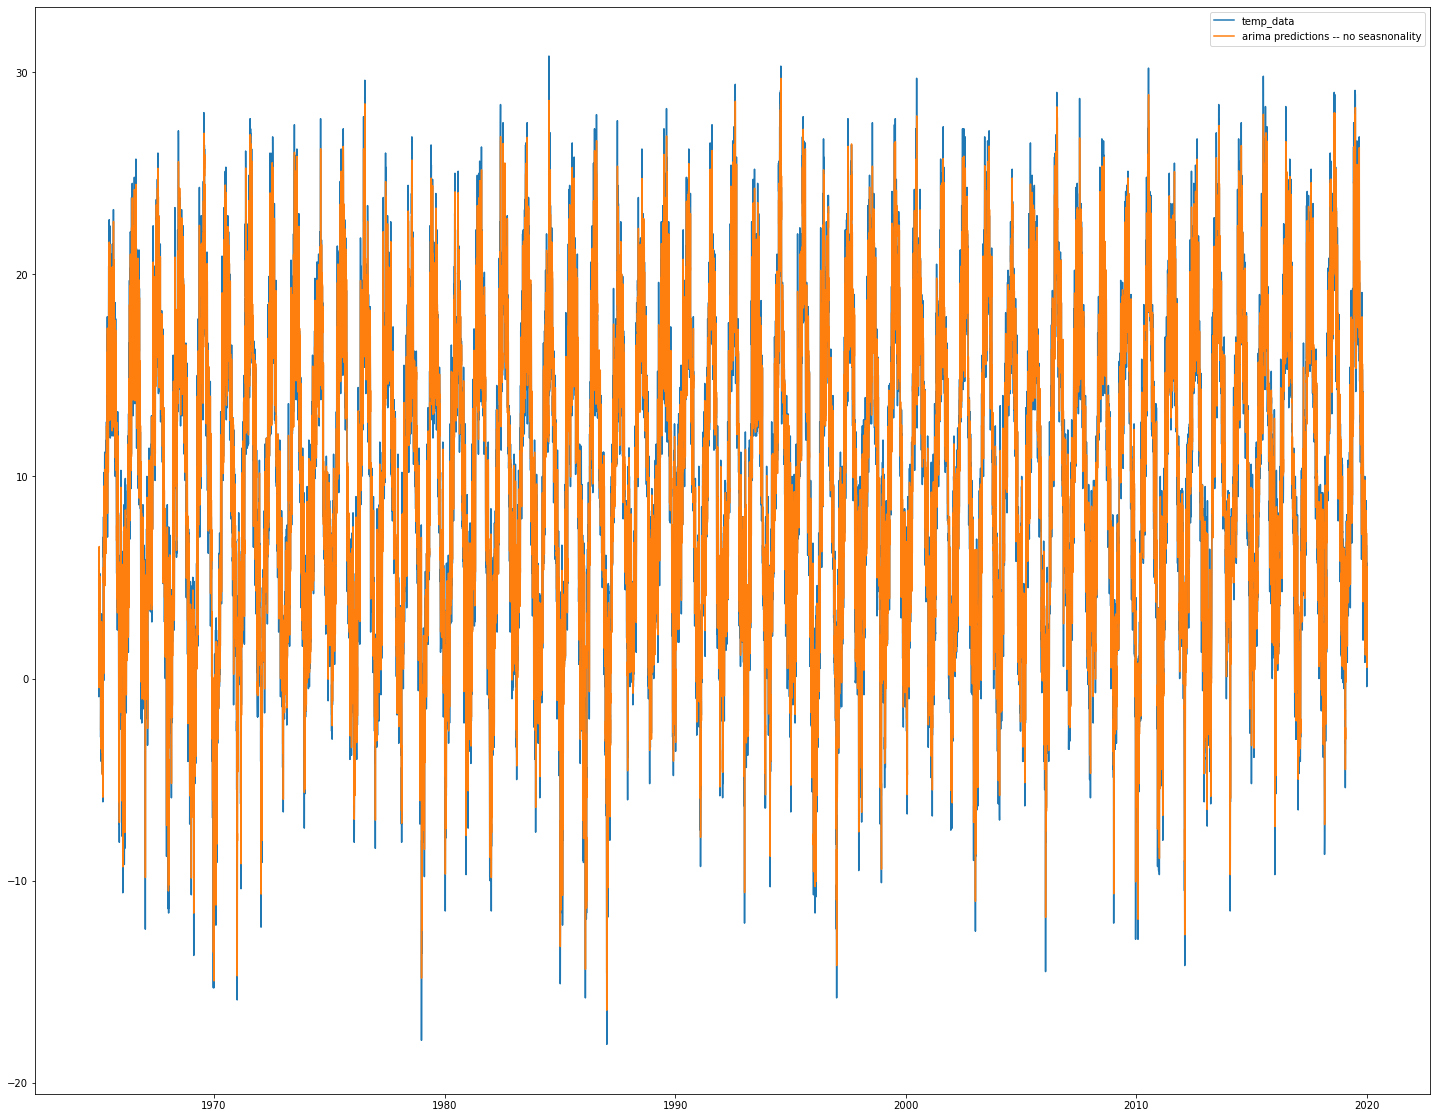

In [92]:
plt.plot(df_train['temp'], label='temp_data')
plt.plot(model.predict(), label='arima predictions -- no seasnonality')
plt.legend()

plt.show()

# Model with seasonality

In [93]:
seasonal_dummies = pd.get_dummies(df_train.index.month,
                                  prefix='month',
                                  drop_first=False).set_index(df_train.index)

df_train = df_train.join(seasonal_dummies)

In [94]:
model_season = ARIMA(df_train['temp'], order=(4,1,1), exog=seasonal_dummies).fit()

# Compare real labels vs predicted by ARIMA with vs without seasonality

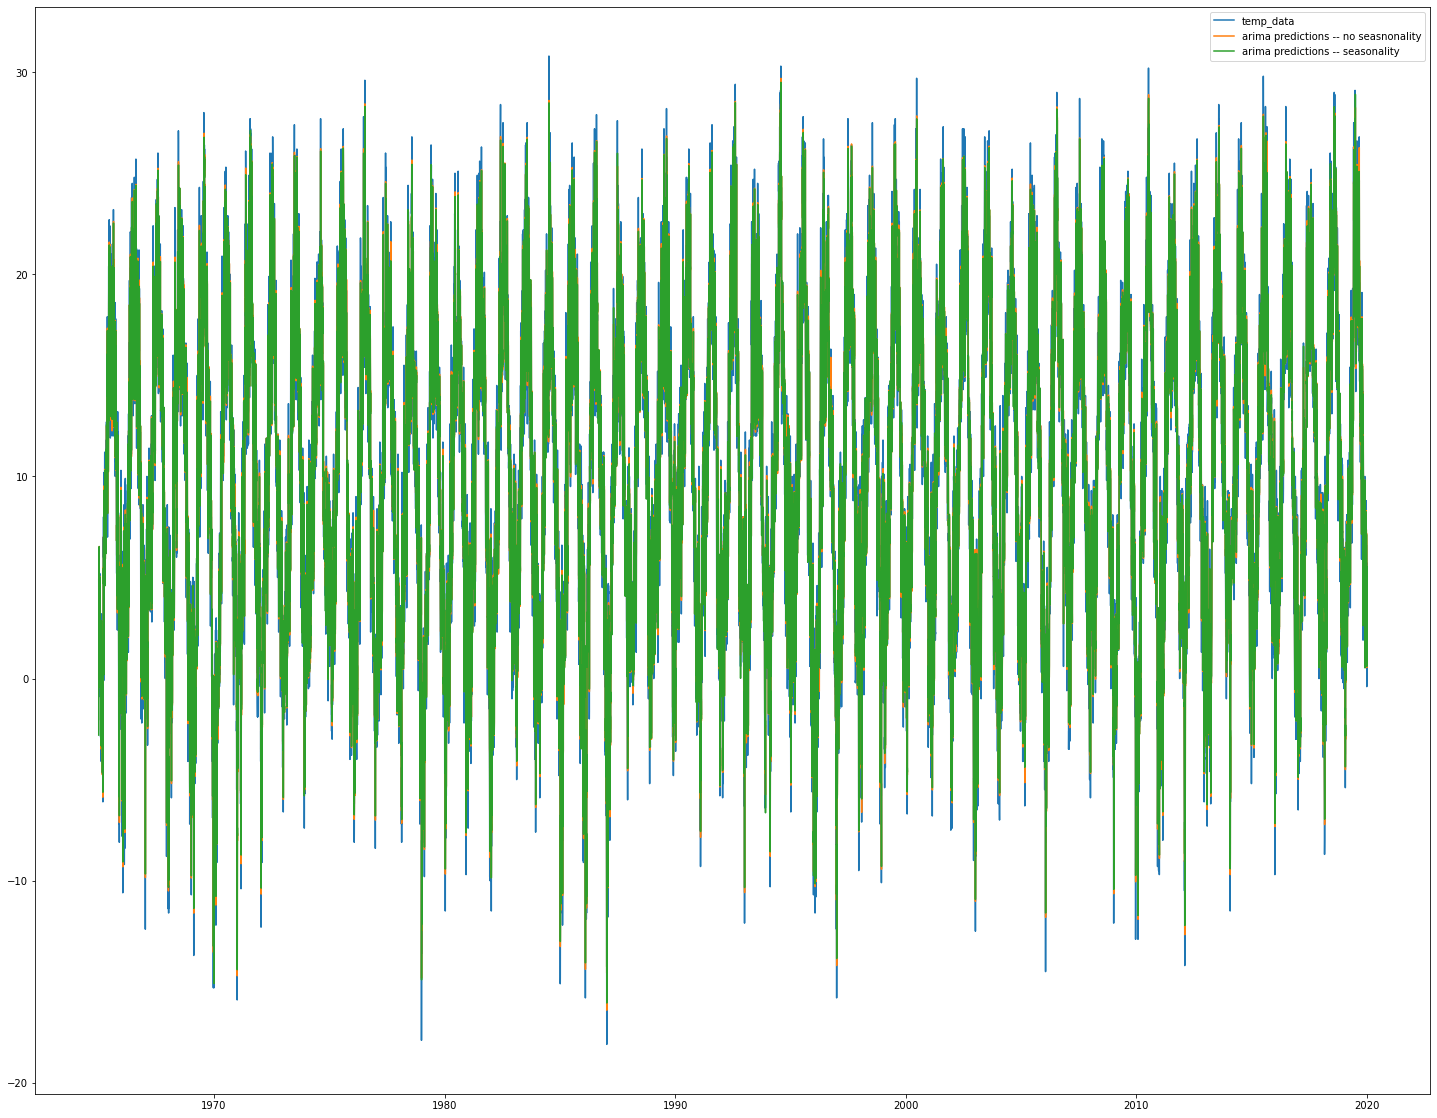

In [95]:
plt.plot(df_train['temp'], label='temp_data')
plt.plot(model.predict(), label='arima predictions -- no seasnonality')
plt.plot(model_season.predict(), label='arima predictions -- seasonality')
plt.legend()

plt.show()

# Check which model is better on training data ?

In [96]:
rmse_no_seasonality = np.sqrt(mean_squared_error(df_train['temp'], model.predict()))

rmse_seasonality = np.sqrt(mean_squared_error(df_train['temp'], model_season.predict()))

In [97]:
rmse_no_seasonality, rmse_seasonality

(2.3528925047546476, 2.346848667906702)

# Multiple steps out-of-sample predictions

In [98]:
model.forecast(steps=12)

2020-01-01    5.255391
2020-01-02    4.993180
2020-01-03    4.867170
2020-01-04    4.776843
2020-01-05    4.715907
2020-01-06    4.678618
2020-01-07    4.655790
2020-01-08    4.641617
2020-01-09    4.632839
2020-01-10    4.627420
2020-01-11    4.624075
2020-01-12    4.622008
Freq: D, Name: predicted_mean, dtype: float64

# Predict temprature in 2020 based on ARIMA with seasonality

In [99]:
model_season.predict(start='2020-01-01', end='2020-12-31', exog=seasonal_dummies.iloc[0:366])

2020-01-01     4.873612
2020-01-02     4.609564
2020-01-03     4.514254
2020-01-04     4.452852
2020-01-05     4.404571
2020-01-06     4.370618
2020-01-07     4.347735
2020-01-08     4.332148
2020-01-09     4.321441
2020-01-10     4.314092
2020-01-11     4.309055
2020-01-12     4.305603
2020-01-13     4.303236
2020-01-14     4.301614
2020-01-15     4.300502
2020-01-16     4.299739
2020-01-17     4.299216
2020-01-18     4.298858
2020-01-19     4.298612
2020-01-20     4.298444
2020-01-21     4.298329
2020-01-22     4.298249
2020-01-23     4.298195
2020-01-24     4.298158
2020-01-25     4.298133
2020-01-26     4.298115
2020-01-27     4.298103
2020-01-28     4.298095
2020-01-29     4.298089
2020-01-30     4.298085
2020-01-31     4.298083
2020-02-01     4.686674
2020-02-02     4.686673
2020-02-03     4.686672
2020-02-04     4.686671
2020-02-05     4.686671
2020-02-06     4.686671
2020-02-07     4.686671
2020-02-08     4.686670
2020-02-09     4.686670
2020-02-10     4.686670
2020-02-11     4

# Apply trained model on test data

In [100]:
df_test = pd.read_csv('df_test.csv')

In [101]:
df_test['date'] = df_test['date'].astype(str)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.set_index('date')

In [102]:
df_test['temp_ARIMA'] = model.forecast(steps=366).values

df_test['temp_ARIMA_season'] = model_season.forecast(steps=366, exog=seasonal_dummies.iloc[0:366]).values

In [103]:
df_test.head()

,temp,temp_ARIMA,temp_ARIMA_season
date,,,
2020-01-01,1.7,5.255391,4.873612
2020-01-02,0.5,4.993180,4.609564
2020-01-03,4.5,4.867170,4.514254
2020-01-04,3.9,4.776843,4.452852
2020-01-05,1.2,4.715907,4.404571


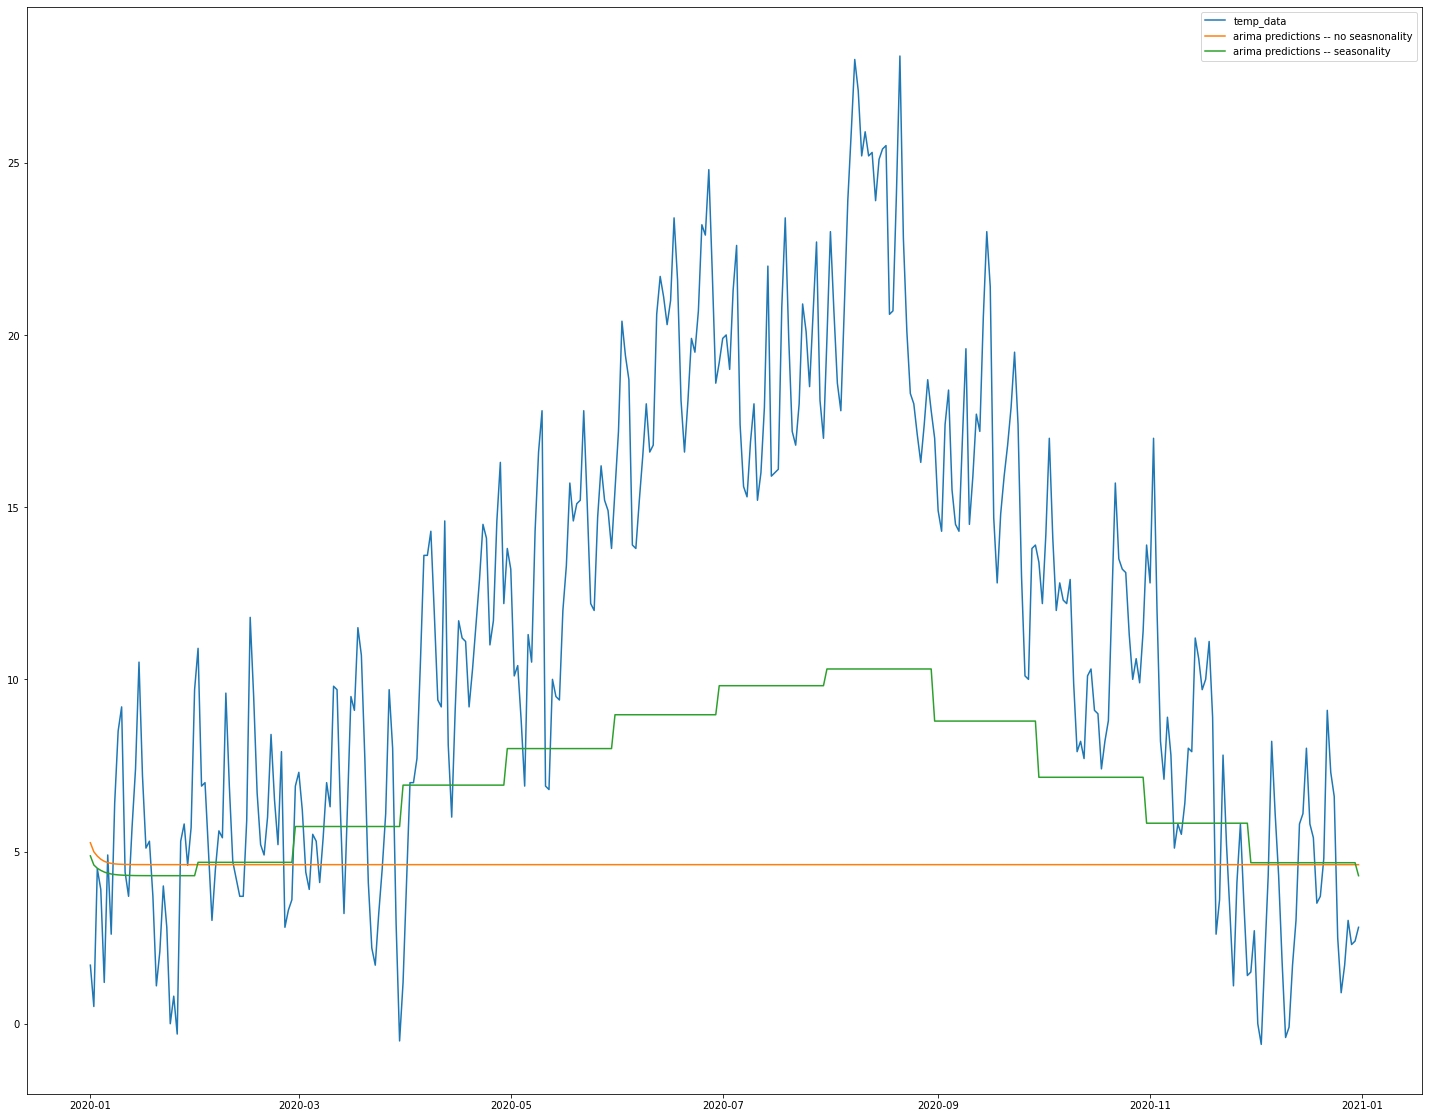

In [104]:
plt.plot(df_test['temp'], label='temp_data')
plt.plot(df_test['temp_ARIMA'], label='arima predictions -- no seasnonality')
plt.plot(df_test['temp_ARIMA_season'], label='arima predictions -- seasonality')
plt.legend()

plt.show()